In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import scipy.stats as stats
import xgboost as xgb

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet, LassoLarsIC, Lasso, BayesianRidge, Ridge, LassoLars, LassoLarsCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, ParameterSampler


In [74]:
trends = pd.read_csv('data/sentiment_google.csv')
trends['fecha'] = trends.Month.astype(np.datetime64)

In [89]:
sentiment = df.merge(trends,how='inner',on='fecha')
sentiment2 = sentiment[['tipodepropiedad', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'fecha',
       'precio', 'year', 'fecha_mes',
       'precio_constantes', 'Month', 'comprar casa: (Mexico)',
       'vender casa: (Mexico)']]
sentimentCasas = sentiment.loc[(sentiment2.tipodepropiedad=='Casa') & (sentiment2.habitaciones==3)]

In [2]:
# Ojo la carpeta donde se guarda.
df = pd.read_csv('data/train.csv', error_bad_lines=False)

In [3]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

In [21]:
# Cargo la serie de inflación.
inflacion_mex = pd.read_csv('./data/inflacion_mex.csv',names=['fecha_mes','indice'],parse_dates=['fecha_mes'],dtype={'indice':np.float64})
# Cambio de base al ultimo dato.
infla2019 = inflacion_mex['indice'].tail(1).values[0]
inflacion_mex['indice'] = (inflacion_mex['indice']/infla2019)*100
# Elimino el número de día para poder joinear ambos DF.
inflacion_mex['fecha_mes'] = inflacion_mex['fecha_mes'].dt.to_period('M')
df['fecha_mes']= df['fecha'].dt.to_period('M')
df = df.merge(inflacion_mex,how='inner',on='fecha_mes')
df['precio_constantes'] = (df['precio']/df['indice'])*100

In [14]:
df['fecha']= pd.to_datetime(df['fecha'], errors='coerce')
df['year']=df.fecha.dt.year

[(0, 5500000)]

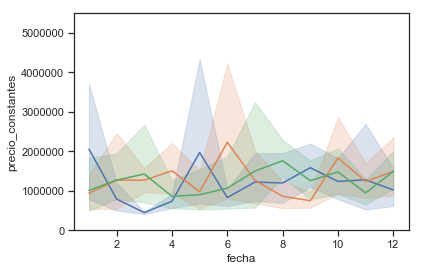

In [71]:
casash12 = df.loc[(df.tipodepropiedad=='Casa') & (df.habitaciones==1)&(df.year==2012)]
casash13 = df.loc[(df.tipodepropiedad=='Casa') & (df.habitaciones==1)&(df.year==2013)]
casash14 = df.loc[(df.tipodepropiedad=='Casa') & (df.habitaciones==1)&(df.year==2014)]

#casash2 = df.loc[(df.tipodepropiedad=='Casa') & (df.habitaciones==2)&(df.year==2012)]
#casash3 = df.loc[(df.tipodepropiedad=='Casa') & (df.habitaciones==3)&(df.year==2012)]
#casash4 = df.loc[(df.tipodepropiedad=='Casa') & (df.habitaciones==4)&(df.year==2012)]
sns.set(style="darkgrid")
sns.set(style="ticks", color_codes=True)
g = sns.lineplot(x=casash12.fecha.dt.month, y='precio_constantes', data=casash12)
g = sns.lineplot(x=casash13.fecha.dt.month, y='precio_constantes', data=casash13)
g = sns.lineplot(x=casash14.fecha.dt.month, y='precio_constantes', data=casash14)
#g = sns.lineplot(x='fecha', y='precio_constantes', data=casash2)
#g = sns.lineplot(x='fecha', y='precio_constantes', data=casash3)
#g = sns.lineplot(x='fecha', y='precio_constantes', data=casash4)
g.set(ylim=(0, 5500000))

In [22]:
zp12= df.loc[df.year==2012]
zp13= df.loc[df.year==2013]
zp14= df.loc[df.year==2014]
zp15= df.loc[df.year==2015]
zp16= df.loc[df.year==2016]
zp17= df.loc[df.year==2017]

In [24]:
zp12s=zp12.sample(2000)

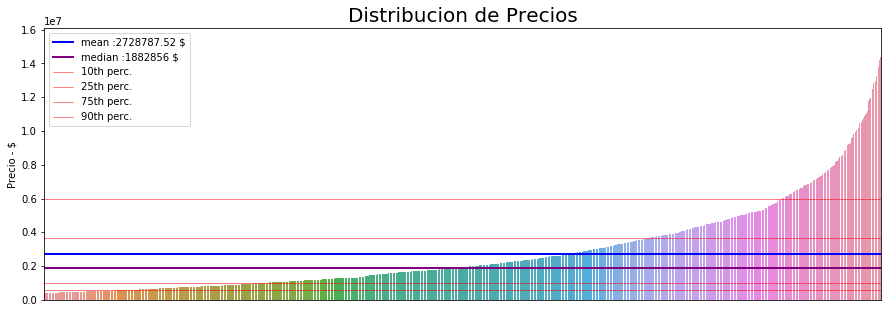

count       2000.00
mean     2728787.52
std      2441423.26
min       404557.61
25%       990184.27
50%      1882856.24
75%      3673747.19
max     15334038.40
Name: precio_constantes, dtype: float64

In [25]:
fig, ax = plt.subplots(figsize=[15,5])

sns.barplot(x=zp12s['precio_constantes'],y=zp12s['precio_constantes'].sort_values())
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(False)

plt.axhline(zp12s['precio_constantes'].mean(),c = 'b', linewidth = 2, label = "mean :" + "%.2f"%zp12s['precio_constantes'].mean()+ " $")
plt.axhline(zp12s['precio_constantes'].median(),c = 'purple', linewidth = 2, label = "median :" + "%.0f"%zp12s['precio_constantes'].median()+ " $")

for i, quantile in enumerate([.1, 0.25, .75, .9]):
    ax.axhline(zp12s['precio_constantes'].quantile(quantile), label='%.0fth perc.' % (quantile*100), color = 'r', linewidth = 0.5)
    
plt.ylabel("Precio - $")
plt.legend()
plt.title('Distribucion de Precios',fontsize = 20)
plt.show()
zp12s['precio_constantes'].describe()

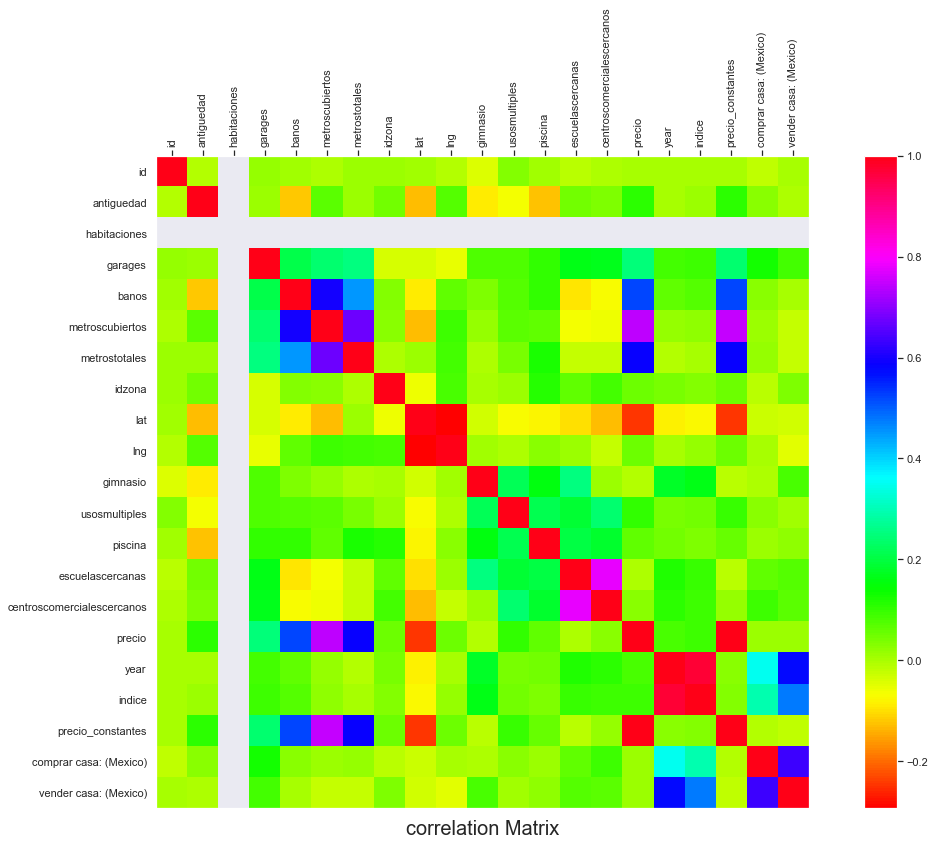

In [90]:
cor = sentimentCasas.corr()
upper = cor.where(np.triu(np.ones(cor.shape), k=1).astype(np.bool))


fig, ax = plt.subplots(figsize=[20,12])

plt.title("correlation Matrix", fontsize = 20, y=-0.05)
image = ax.imshow(cor, cmap = 'hsv')

plt.xticks(np.arange(len(cor.columns)),cor.columns, rotation = 'vertical')
ax.xaxis.tick_top()
plt.yticks(np.arange(len(cor.columns)),cor.columns, rotation = 'horizontal')
fig.colorbar(image, ax=ax)
plt.rcParams['grid.color'] = "w"
plt.grid()
plt.show()

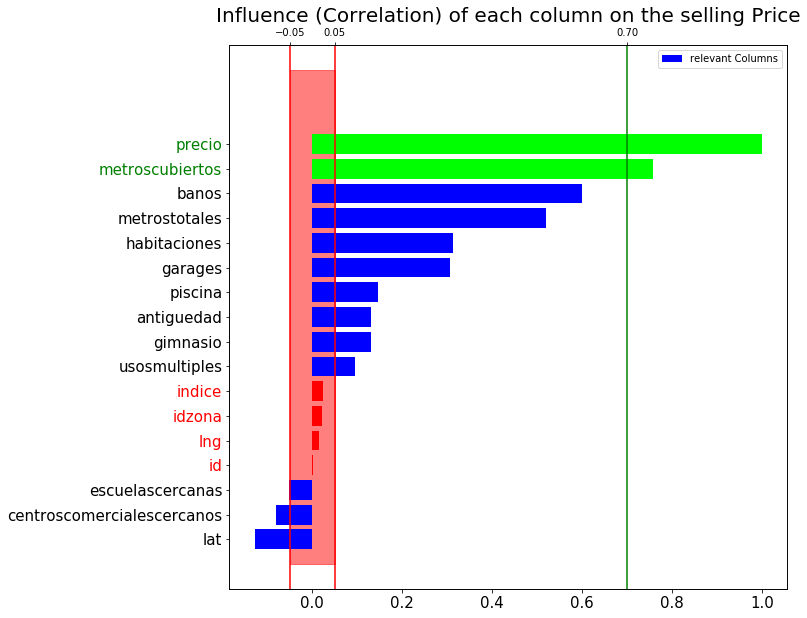

In [27]:
#order the correlations and their associated column
minCorrValue = 0.05
goodCorrValue = 0.7

corrOrdered = list(upper['precio_constantes'].copy().sort_values())
numNan = upper['precio_constantes'].isnull().sum()
colOrdered = [upper.columns[list(upper['precio_constantes']).index(x)] for x in corrOrdered[:-numNan]]

# We have colOrdered, corrOrdered, numNan, lowCorrelatedColumns

lowCorrelatedColumns, highCorrelatedColumns = [], []

#get the high and low correlated columns + color
colorList= ['b']*len(colOrdered)
for x in corrOrdered:
    if abs(x) in [x for x in list(upper['precio_constantes'].abs()) if x<minCorrValue]:
        colorList[corrOrdered.index(x)] = 'r'                    #undecoralated columns are red
        lowCorrelatedColumns.append(colOrdered[corrOrdered.index(x)])
    if abs(x) in [x for x in list(upper['precio_constantes'].abs()) if x>goodCorrValue]:
        colorList[corrOrdered.index(x)] = 'lime'                    #undecoralated columns are red
        highCorrelatedColumns.append(colOrdered[corrOrdered.index(x)])
                        
            
plt.figure(figsize=[10,10])
plt.barh(colOrdered,corrOrdered[:-numNan], color=colorList)
plt.title("Influence (Correlation) of each column on the selling Price", fontsize=20)
plt.tick_params(labelsize=15)
plt.legend( ['relevant Columns','good'])
plt.axvline(x= minCorrValue, c='r')
plt.fill_between([-minCorrValue,minCorrValue], [len(upper),len(upper)],[-1,-1], alpha = 0.5, color = 'red')
plt.axvline(x= -minCorrValue, c='r')
plt.axvline(x= goodCorrValue, c='g')
ax = plt.gca()
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([-minCorrValue,minCorrValue,goodCorrValue])

#color the yticks
for x in lowCorrelatedColumns:
        ax.get_yticklabels()[colOrdered.index(x)].set_color("red")
for x in highCorrelatedColumns:
        ax.get_yticklabels()[colOrdered.index(x)].set_color("green")

plt.show()
#print("Low correlatedColumns", lowCorrelatedColumns)

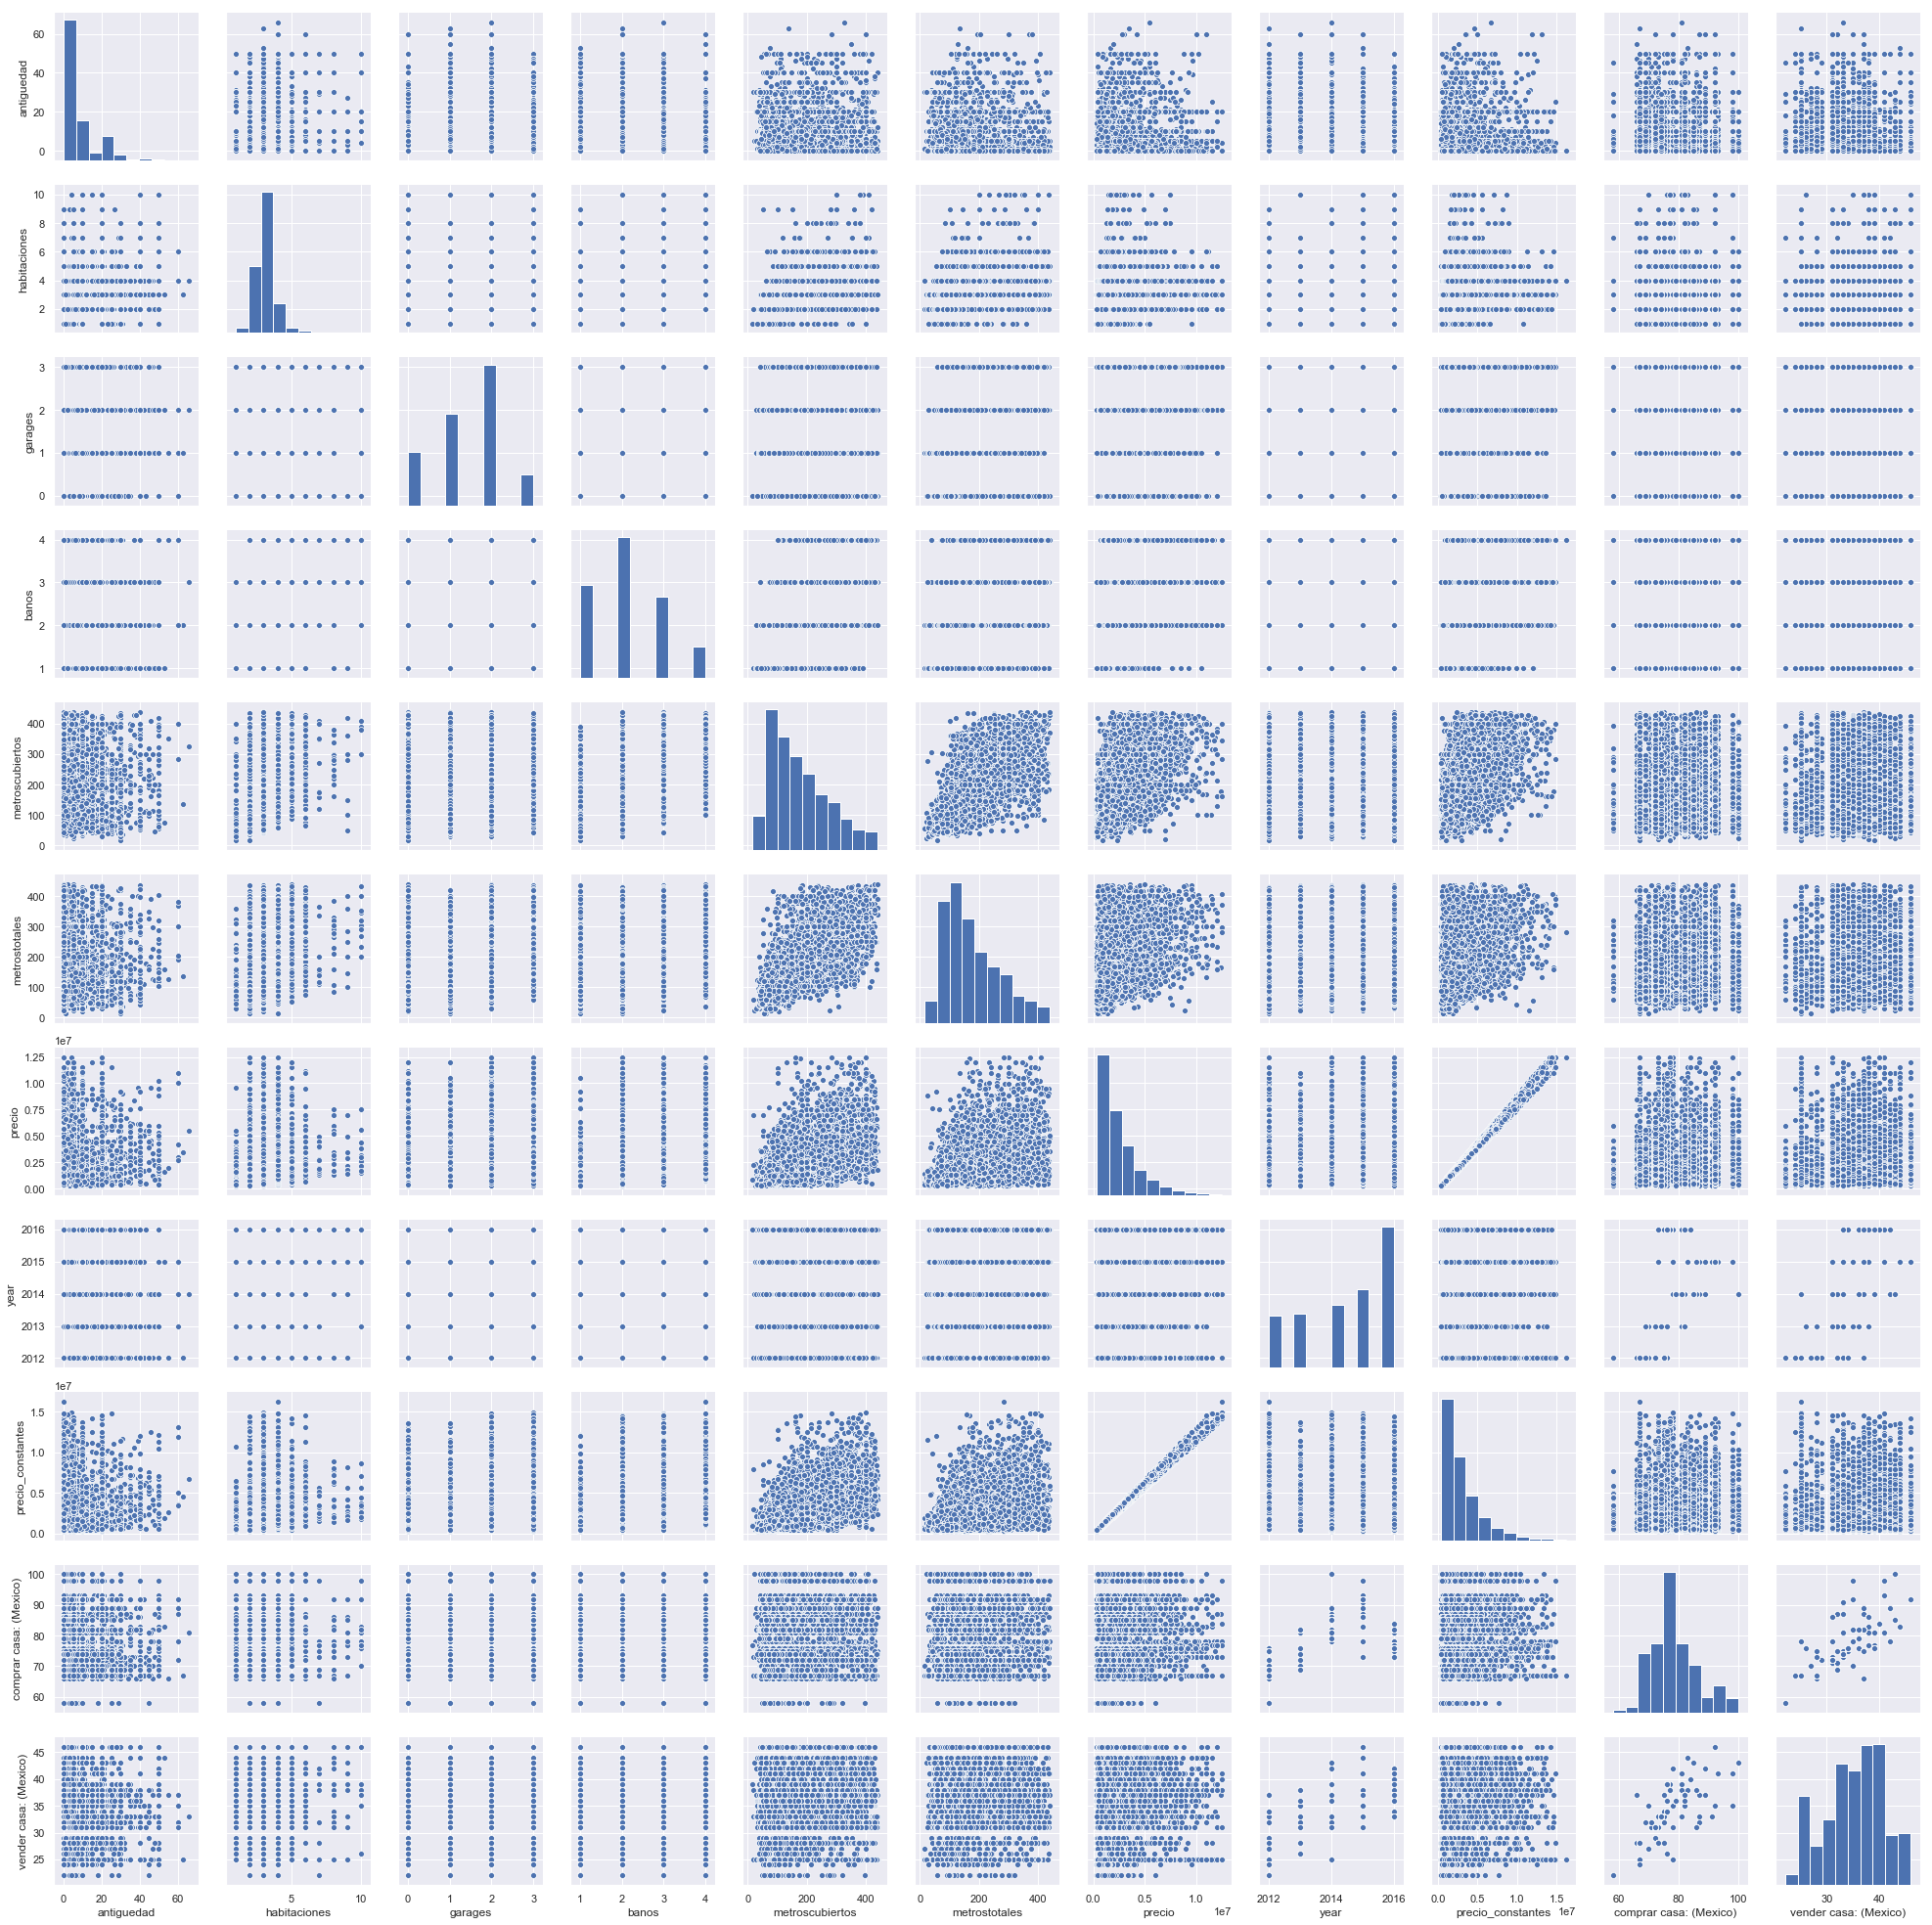

In [86]:
#scatterplot
sns.set()
#cols = ['precio','year','metroscubiertos','banos','metrostotales','habitaciones','garages','piscina','antiguedad','gimnasio']
sns.pairplot(sentiment2, height = 2.5)
plt.show()

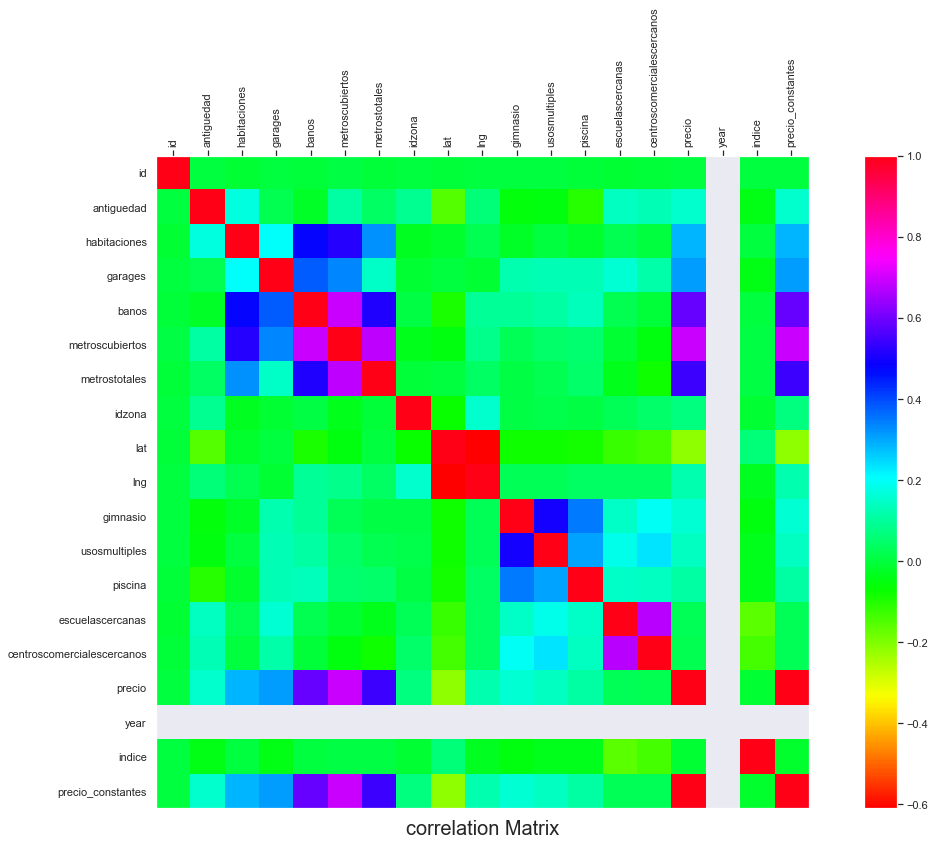

In [30]:
cor = zp13.corr()
upper = cor.where(np.triu(np.ones(cor.shape), k=1).astype(np.bool))


fig, ax = plt.subplots(figsize=[20,12])

plt.title("correlation Matrix", fontsize = 20, y=-0.05)
image = ax.imshow(cor, cmap = 'hsv')

plt.xticks(np.arange(len(cor.columns)),cor.columns, rotation = 'vertical')
ax.xaxis.tick_top()
plt.yticks(np.arange(len(cor.columns)),cor.columns, rotation = 'horizontal')
fig.colorbar(image, ax=ax)
plt.rcParams['grid.color'] = "w"
plt.grid()
plt.show()

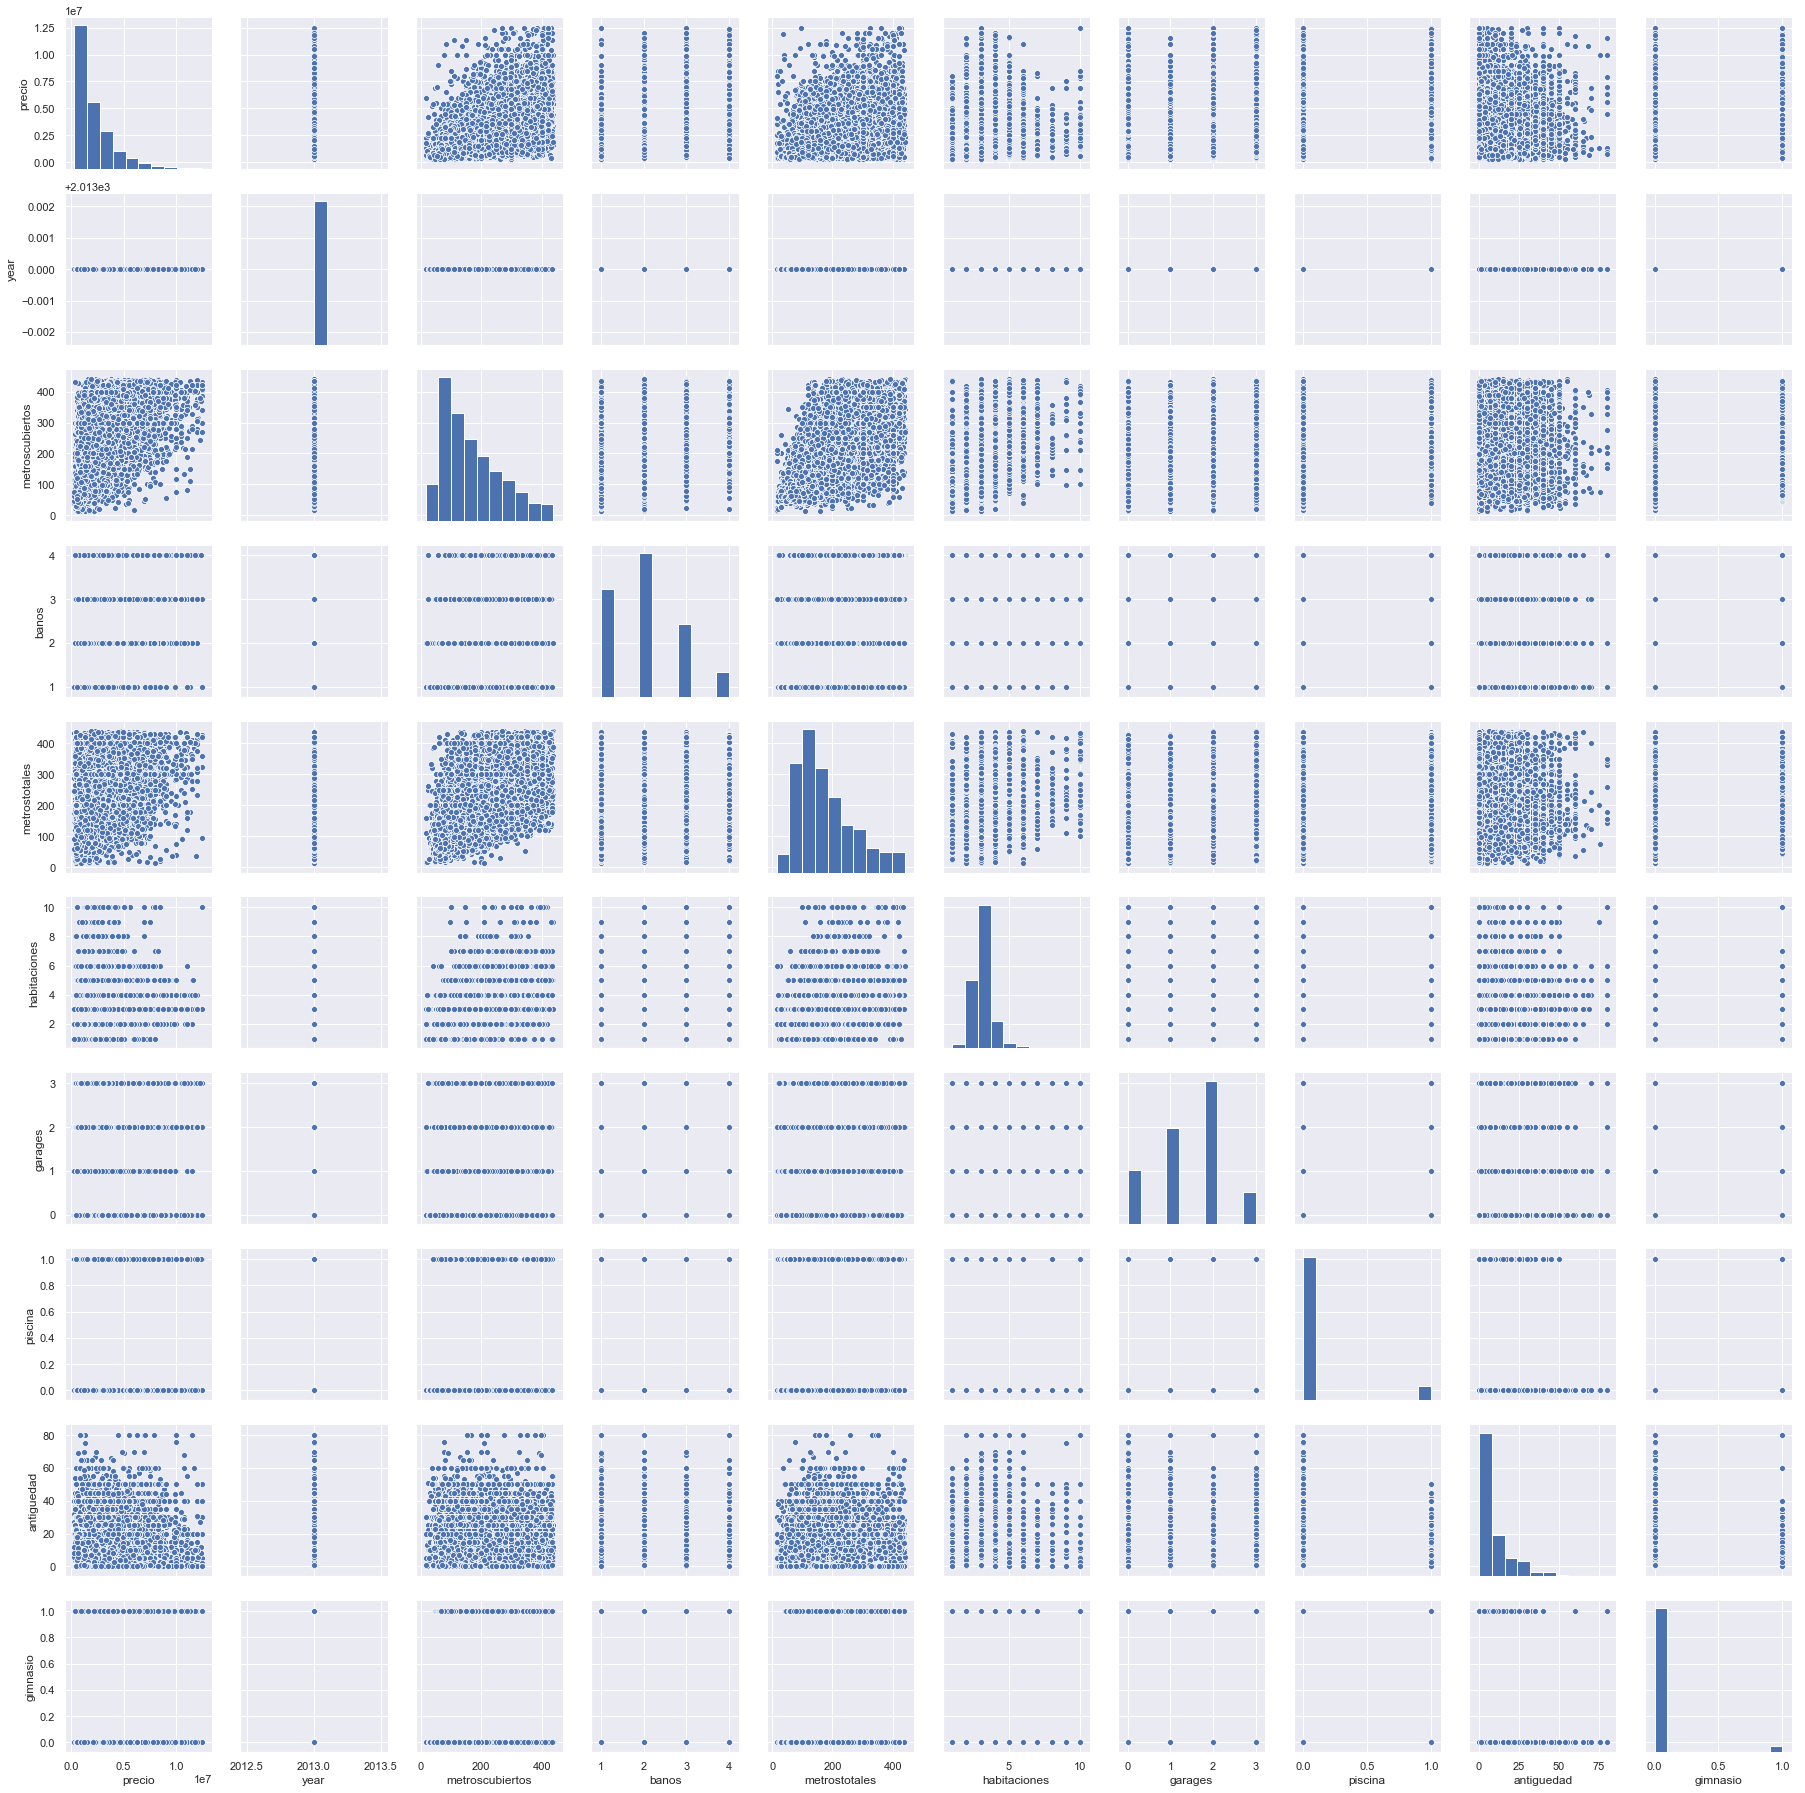

In [31]:
#scatterplot
sns.set()
cols = ['precio','year','metroscubiertos','banos','metrostotales','habitaciones','garages','piscina','antiguedad','gimnasio']
sns.pairplot(zp13[cols], height = 2.5)
plt.show()

C:\Users\NicolasIzcovich\Anaconda3\lib\site-packages\scipy\stats\stats.py:2923: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / float(len(a))


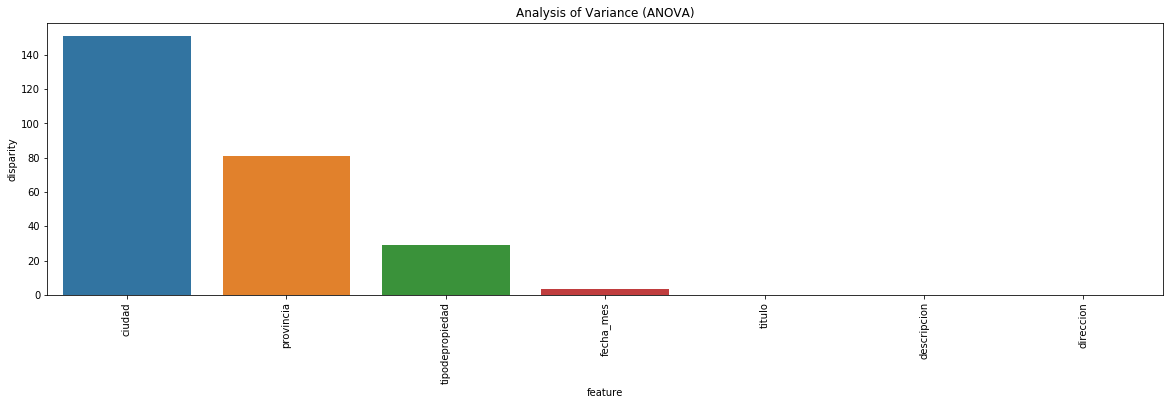

In [28]:
qualitative = zp12s.select_dtypes('object').columns

plt.figure(figsize = [20,5])
anova = pd.DataFrame(columns = ['feature','pvalue'])
anova['feature'] = qualitative
for col in qualitative: #for each qualitative column we get the pvalues
    samples = []
    for elt in zp12s[col].unique():
        samples.append(zp12s['precio'][zp12s[col] == elt].values)
    a = stats.f_oneway(*samples)
    anova['pvalue'][anova['feature']==col] = a.pvalue
    
#sort and cast
anova = anova.sort_values('pvalue')
anova['pvalue'] = anova['pvalue'].astype('float') 
#transform for better visualisation and plot
anova['disparity'] = np.log(1./anova['pvalue'].values)
#anova.plot(kind='bar',x = 'feature',y = 'disparity', cmap = 'rainbow')
sns.barplot(data=anova, x='feature', y='disparity')
x=plt.xticks(rotation=90)
plt.title('Analysis of Variance (ANOVA)')
plt.show()

In [4]:
nulls = pd.DataFrame(df.isnull().sum().sort_values(), columns=['nulls'])
nulls['porcentaje'] = round(100*nulls['nulls'] / len(df), 2)
nulls

,nulls,porcentaje
precio,0,0.00
escuelascercanas,0,0.00
piscina,0,0.00
usosmultiples,0,0.00
gimnasio,0,0.00
fecha,0,0.00
centroscomercialescercanos,0,0.00
tipodepropiedad,46,0.02
provincia,155,0.06
ciudad,372,0.16


In [6]:
df.dtypes

titulo                                object
descripcion                           object
tipodepropiedad                       object
direccion                             object
ciudad                                object
provincia                             object
antiguedad                           float64
habitaciones                         float64
garages                              float64
banos                                float64
metroscubiertos                      float64
metrostotales                        float64
idzona                               float64
lat                                  float64
lng                                  float64
fecha                         datetime64[ns]
gimnasio                             float64
usosmultiples                        float64
piscina                              float64
escuelascercanas                     float64
centroscomercialescercanos           float64
precio                               float64
dtype: obj

In [7]:
df.get_dtype_counts()

float64           15
datetime64[ns]     1
object             6
dtype: int64

df.info()

In [8]:
# Memory Usage
(df.memory_usage() / (1024 * 1024)).sum()

42.1142578125

In [5]:
print("Valores únicos piscina: ", df.piscina.unique())
print("Valores únicos usos multiples: ", df.usosmultiples.unique())
print("Valores únicos escuelas cercanas: ", df.escuelascercanas.unique())
print("Valores únicos centros comerciales cercanos: ", df.centroscomercialescercanos.unique())

Valores únicos piscina:  [0. 1.]
Valores únicos usos multiples:  [0. 1.]
Valores únicos escuelas cercanas:  [0. 1.]
Valores únicos centros comerciales cercanos:  [0. 1.]


In [5]:
# Como castear campos bool a int 16
df = df.astype({"piscina": 'int16', "usosmultiples": 'int16', "escuelascercanas": 'int16', "centroscomercialescercanos": 'int16'})
# Cambio en memoria
(df.memory_usage() / (1024 * 1024)).sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240000 entries, 254099 to 121958
Data columns (total 22 columns):
titulo                        234613 non-null object
descripcion                   238381 non-null object
tipodepropiedad               239954 non-null object
direccion                     186928 non-null object
ciudad                        239628 non-null object
provincia                     239845 non-null object
antiguedad                    196445 non-null float64
habitaciones                  217529 non-null float64
garages                       202235 non-null float64
banos                         213779 non-null float64
metroscubiertos               222600 non-null float64
metrostotales                 188533 non-null float64
idzona                        211379 non-null float64
lat                           116512 non-null float64
lng                           116512 non-null float64
fecha                         240000 non-null datetime64[ns]
gimnasio           

In [12]:
# here are all the attributes of both a pandas Series and a pandas DF
s_attr_methods = set(dir(pd.Series))
df_attr_methods = set(dir(pd.DataFrame))
len(s_attr_methods & df_attr_methods) #they share 400 methods

399

In [13]:
ciudad=df.ciudad
ciudad.value_counts().head()

Querétaro          12646
Benito Juárez      11014
Zapopan            10360
San Luis Potosí     7925
Mérida              7162
Name: ciudad, dtype: int64

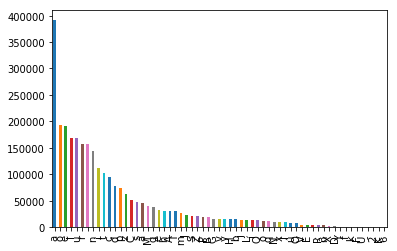

In [14]:
pd.Series(list(df.ciudad.str.cat())).value_counts().plot(kind="bar")

In [15]:
# Bring only columns with a certain type
df.select_dtypes('number')

,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio
id,,,,,,,,,,,,,,,
254099,nan,2.00,1.00,2.00,80.00,80.00,23533.00,nan,nan,0.00,0,0,0,0,2273000.00
53461,10.00,3.00,2.00,2.00,268.00,180.00,24514.00,19.31,-99.23,0.00,0,0,1,1,3600000.00
247984,5.00,3.00,2.00,2.00,144.00,166.00,48551.00,nan,nan,0.00,0,0,0,0,1200000.00
209067,1.00,2.00,1.00,1.00,63.00,67.00,53666.00,19.30,-99.69,0.00,0,0,1,1,650000.00
185997,10.00,2.00,1.00,1.00,95.00,95.00,47835.00,nan,nan,0.00,0,0,0,0,1150000.00
126147,5.00,2.00,1.00,1.00,75.00,90.00,23650.00,19.30,-99.15,0.00,0,0,0,1,1100000.00
139233,nan,3.00,1.00,2.00,140.00,160.00,73510.00,17.14,-96.80,0.00,0,0,0,0,1150000.00
5013,2.00,4.00,2.00,3.00,293.00,293.00,130510.00,20.67,-87.04,0.00,0,0,0,0,4200000.00
44962,1.00,2.00,1.00,1.00,58.00,nan,9010.00,nan,nan,0.00,0,0,1,1,310000.00


In [16]:
# DF tiene un indice (matriz), Serie tiene un indice (vector), la lista no.

counts_ciudad = df.ciudad.value_counts().tolist()
print(counts_ciudad)

[12646, 11014, 10360, 7925, 7162, 6946, 6633, 6614, 6554, 5795, 5783, 5721, 5718, 5293, 4636, 4006, 3805, 3779, 3775, 3757, 3588, 3408, 3254, 3141, 3093, 3020, 2863, 2590, 2454, 2159, 2048, 2026, 2018, 1996, 1972, 1905, 1887, 1865, 1845, 1470, 1457, 1452, 1429, 1386, 1370, 1360, 1342, 1294, 1292, 1285, 1249, 1245, 1207, 1066, 1055, 1046, 1029, 1029, 1000, 952, 931, 871, 861, 857, 832, 800, 793, 773, 759, 747, 728, 725, 665, 651, 627, 620, 617, 578, 574, 565, 553, 548, 523, 521, 520, 513, 485, 460, 459, 449, 444, 420, 418, 384, 378, 369, 351, 340, 329, 307, 293, 289, 287, 285, 279, 278, 267, 267, 264, 262, 246, 242, 240, 236, 235, 231, 229, 221, 211, 208, 195, 190, 177, 161, 154, 150, 147, 146, 146, 144, 133, 130, 130, 129, 126, 126, 124, 121, 120, 116, 111, 111, 110, 106, 102, 101, 91, 86, 85, 83, 83, 78, 77, 75, 75, 74, 74, 73, 70, 69, 68, 68, 67, 67, 65, 65, 61, 60, 56, 56, 56, 55, 54, 54, 54, 50, 50, 49, 48, 48, 47, 47, 47, 46, 45, 44, 43, 40, 40, 39, 39, 39, 38, 38, 36, 36, 35, 35,

In [17]:
#REVISAR
df.ciudad.value_counts().head()

Querétaro          12646
Benito Juárez      11014
Zapopan            10360
San Luis Potosí     7925
Mérida              7162
Name: ciudad, dtype: int64

In [15]:
df.isnull().any()

titulo                         True
descripcion                    True
tipodepropiedad                True
direccion                      True
ciudad                         True
provincia                      True
antiguedad                     True
habitaciones                   True
garages                        True
banos                          True
metroscubiertos                True
metrostotales                  True
idzona                         True
lat                            True
lng                            True
fecha                         False
gimnasio                      False
usosmultiples                 False
piscina                       False
escuelascercanas              False
centroscomercialescercanos    False
precio                        False
dtype: bool

In [16]:
df.isnull().sum()

titulo                          5387
descripcion                     1619
tipodepropiedad                   46
direccion                      53072
ciudad                           372
provincia                        155
antiguedad                     43555
habitaciones                   22471
garages                        37765
banos                          26221
metroscubiertos                17400
metrostotales                  51467
idzona                         28621
lat                           123488
lng                           123488
fecha                              0
gimnasio                           0
usosmultiples                      0
piscina                            0
escuelascercanas                   0
centroscomercialescercanos         0
precio                             0
dtype: int64

In [17]:
df.isnull().mean().sort_values()

precio                       0.00
escuelascercanas             0.00
piscina                      0.00
usosmultiples                0.00
gimnasio                     0.00
fecha                        0.00
centroscomercialescercanos   0.00
tipodepropiedad              0.00
provincia                    0.00
ciudad                       0.00
descripcion                  0.01
titulo                       0.02
metroscubiertos              0.07
habitaciones                 0.09
banos                        0.11
idzona                       0.12
garages                      0.16
antiguedad                   0.18
metrostotales                0.21
direccion                    0.22
lat                          0.51
lng                          0.51
dtype: float64

In [21]:
df.describe(include='all')

,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio
count,234613,238381,239954,186928,239628,239845,196445.00,217529.00,202235.00,213779.00,222600.00,188533.00,211379.00,116512.00,116512.00,240000,240000.00,240000.00,240000.00,240000.00,240000.00,240000.00
unique,186191,232187,24,140269,875,32,nan,nan,nan,nan,nan,nan,nan,nan,nan,1830,nan,nan,nan,nan,nan,nan
top,casa en venta,empresa dedicada a los ante notario y regist...,Casa,-,Querétaro,Distrito Federal,nan,nan,nan,nan,nan,nan,nan,nan,nan,2016-12-03 00:00:00,nan,nan,nan,nan,nan,nan
freq,468,119,141717,660,12646,58790,nan,nan,nan,nan,nan,nan,nan,nan,nan,1416,nan,nan,nan,nan,nan,nan
first,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,2012-01-01 00:00:00,nan,nan,nan,nan,nan,nan
last,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,2016-12-31 00:00:00,nan,nan,nan,nan,nan,nan
mean,NaN,NaN,NaN,NaN,NaN,NaN,8.12,2.90,1.55,2.13,174.02,176.77,2423467.82,20.70,-99.51,NaN,0.06,0.06,0.09,0.44,0.40,2530838.35
std,NaN,NaN,NaN,NaN,NaN,NaN,9.55,0.90,0.85,0.91,98.15,94.43,10567938.36,3.14,9.74,NaN,0.24,0.23,0.28,0.50,0.49,2152551.80
min,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1.00,0.00,1.00,15.00,15.00,22.00,-100.89,-125.86,NaN,0.00,0.00,0.00,0.00,0.00,310000.00
25%,NaN,NaN,NaN,NaN,NaN,NaN,0.00,2.00,1.00,1.00,90.00,102.00,24890.00,19.36,-100.98,NaN,0.00,0.00,0.00,0.00,0.00,952772.50


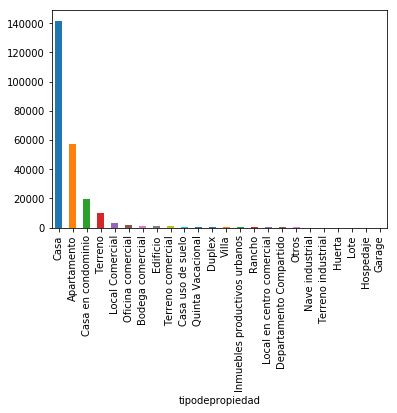

In [18]:
df.groupby(by=['tipodepropiedad']).size().sort_values(ascending=False).plot(kind="bar")

In [19]:
df.index.values.sum()

35992651702

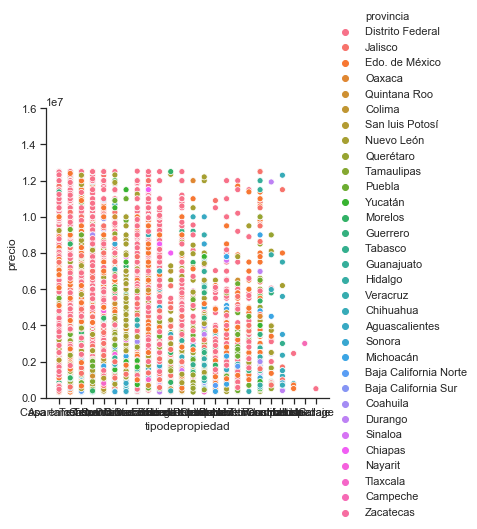

In [24]:
corr_tipoprop_precio = df[['precio', 'tipodepropiedad', 'provincia']]
sns.set(style="darkgrid")
sns.set(style="ticks", color_codes=True)
g = sns.relplot(x='tipodepropiedad', y='precio', data=corr_tipoprop_precio, hue='provincia')
g.set(ylim=(0, 16000000))

In [25]:
df.groupby('provincia').agg({'antiguedad':'mean'}).sort_values('antiguedad')

,antiguedad
provincia,
Baja California Sur,2.46
Yucatán,3.07
Hidalgo,3.47
Tlaxcala,3.69
Querétaro,3.70
Campeche,3.91
San luis Potosí,3.98
Quintana Roo,4.54
Puebla,4.55


AxesSubplot(0.125,0.125;0.775x0.755)
                    tipodepropiedad  porcentaje
Casa                         141717        0.59
Apartamento                   57341        0.24
Casa en condominio            19297        0.08
Terreno                        9945        0.04
Local Comercial                3055        0.01
Oficina comercial              1741        0.01
Bodega comercial               1406        0.01
Edificio                       1396        0.01
Terreno comercial              1326        0.01
Casa uso de suelo               708        0.00


provincia              tipodepropiedad   
Aguascalientes         Casa                  1340
                       Casa en condominio     197
                       Terreno                 86
                       Apartamento             47
                       Local Comercial         31
Baja California Norte  Casa                  2769
                       Apartamento            196
                       Casa en condominio     166
                       Terreno                 24
                       Local Comercial         17
Baja California Sur    Casa                  1473
                       Apartamento             82
                       Terreno                 52
                       Casa en condominio      34
                       Local Comercial         21
Campeche               Casa                   210
                       Terreno                 20
                       Casa en condominio      11
                       Apartamento              7
        

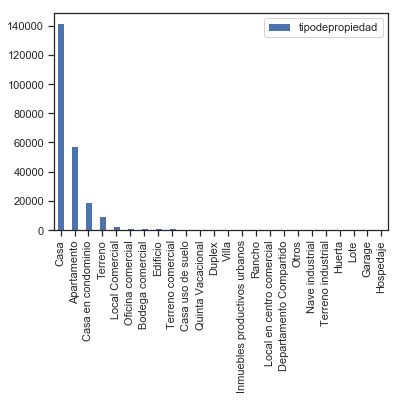

In [26]:
tiposPrincipales = df.tipodepropiedad.value_counts().sort_values(kind="quicksort", ascending=False).to_frame()
print(tiposPrincipales.plot(kind='bar'))
#print(tiposPrincipales.values)
tiposPrincipales['porcentaje'] = tiposPrincipales.values / tiposPrincipales.values.sum()
#print(tiposPrincipales.porcentaje)
print(tiposPrincipales.head(10))

df[df.tipodepropiedad.isin(tiposPrincipales.head(5).tipodepropiedad.index)].groupby(['provincia']).tipodepropiedad.value_counts()

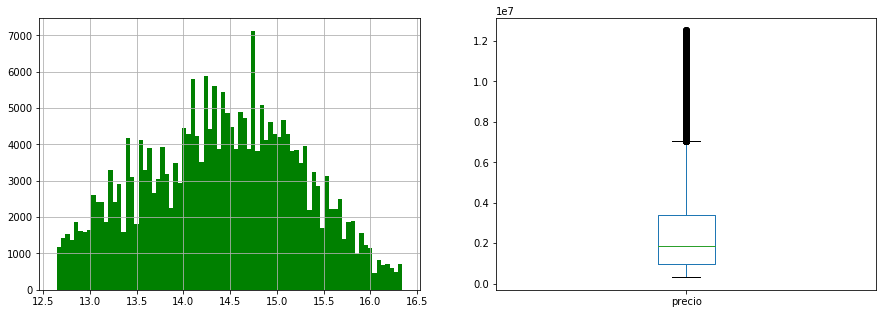

In [21]:
_, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].ticklabel_format(style = 'plain')
#df['precio'].hist(bins=80, ax=axes[0], color='r'); 
np.log(df['precio']).hist(bins=80, ax=axes[0], color='g'); 
df['precio'].plot(kind='box', ax=axes[1]);
plt.show()

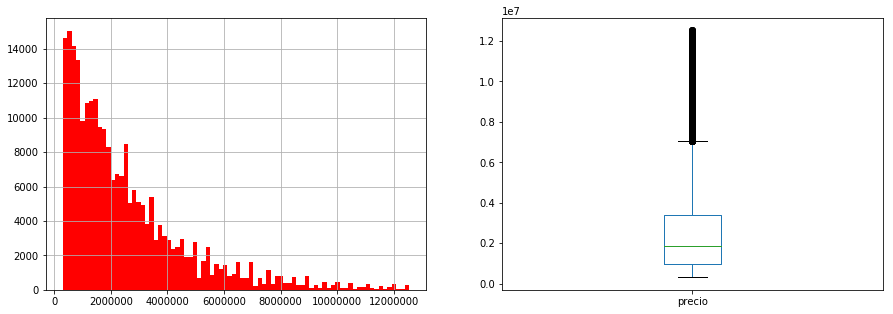

In [22]:
_, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].ticklabel_format(style = 'plain')
df['precio'].hist(bins=80, ax=axes[0], color='r'); 
#np.log(df['precio']).hist(bins=80, ax=axes[0], color='g'); 
df['precio'].plot(kind='box', ax=axes[1]);
plt.show()

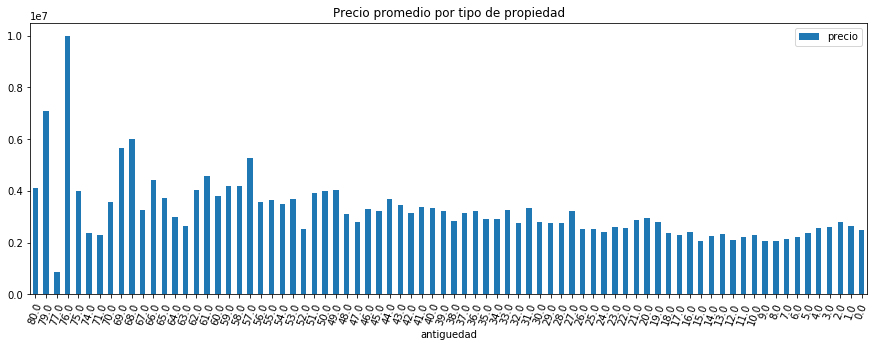

In [6]:
# Precio promedio por tipo de propiedad
df.groupby('antiguedad').agg({'precio': 'mean'})\
    .sort_values('antiguedad', ascending=False)\
    .plot(kind='bar', figsize=(15, 5), rot=70, title="Precio promedio por tipo de propiedad");

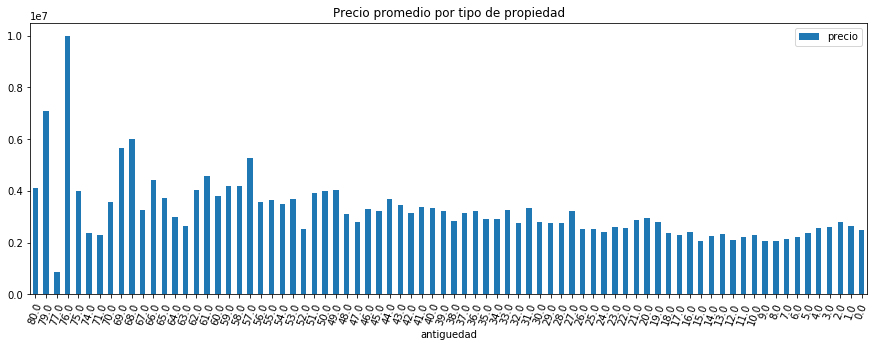

In [11]:
df.groupby('antiguedad').agg({'precio': 'mean'})\
    .sort_values('antiguedad', ascending=False)\
    .plot(kind='bar', figsize=(15, 5), rot=70, title="Precio promedio por tipo de propiedad");

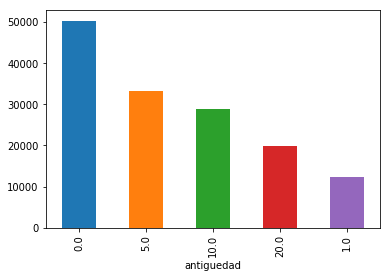

In [16]:
df.groupby(by=['antiguedad']).size().sort_values(ascending=False).nlargest(5).plot(kind='bar')

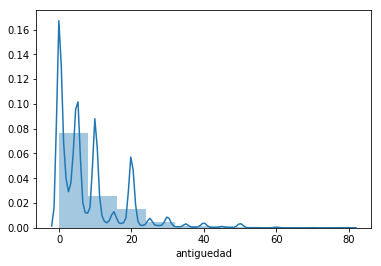

In [18]:
sns.distplot(df['antiguedad'],bins=10)

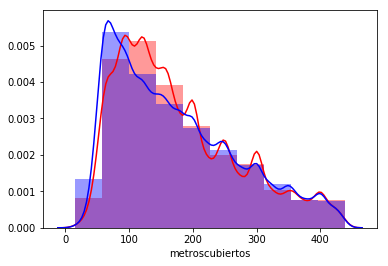

In [28]:
sns.distplot(df['metrostotales'],bins=10,color='red')
sns.distplot(df['metroscubiertos'],bins=10,color ='blue')

C:\Users\NicolasIzcovich\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


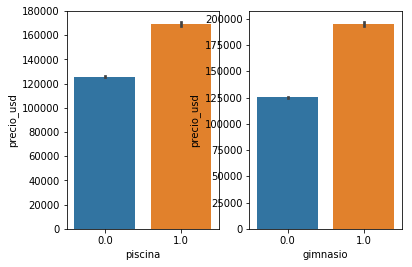

In [45]:
fig, ax =plt.subplots(1,2)
sns.barplot(x=df['piscina'],y=df['precio_usd'],ax=ax[0])
sns.barplot(x=df['gimnasio'],y=df['precio_usd'],ax=ax[1])
fig.show()

In [44]:
df['precio_usd']=df['precio']/19.54

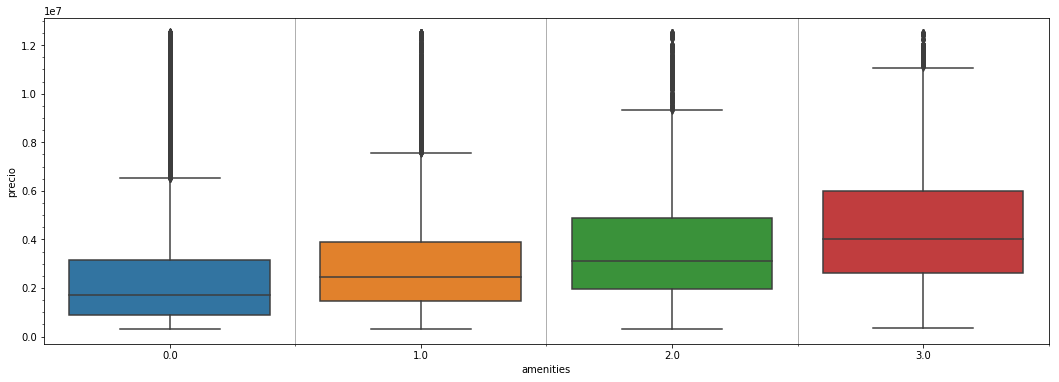

In [48]:
tiposPrincipales = df.tipodepropiedad.value_counts().sort_values(kind="quicksort", ascending=False).to_frame()
df['amenities'] = df.gimnasio + df.usosmultiples + df.piscina #+ df.escuelascercanas + df.centroscomercialescercanos
df['plus']  = df.habitaciones + df.banos + df.garages + df.gimnasio + df.usosmultiples + df.piscina + df.escuelascercanas + df.centroscomercialescercanos

# df[['amenities', 'precio']].plot(x ='amenities', y='precio', kind = '')
dfProps = df[df.tipodepropiedad.isin(tiposPrincipales.head(5).tipodepropiedad.index)]

from matplotlib.ticker import AutoMinorLocator
fig = plt.figure(figsize=(18,6))
ax1 = sns.boxplot('amenities', "precio", data=dfProps) #, hue='modelLine')
ax1.minorticks_on()
ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.grid(which='minor', axis='x', linewidth=1)

In [52]:
df.groupby('amenities')['precio_usd'].mean()

amenities
0.00   122740.47
1.00   153538.46
2.00   190476.63
3.00   231256.79
Name: precio_usd, dtype: float64

In [43]:
# Agrego dos columnas calculadas a partir de la fecha (timestamp y 201602,...)
df['precio_metro_t'] = df['precio'].div(df['metrostotales'].dropna())
df['precio_metro_tcomp'] = df['precio'].apply(lambda x: x*.6)
df['precio_metro_ccomp'] = df['precio'].apply(lambda x: x*.58)
df['precio_metro_c'] = df['precio'].div(df['metroscubiertos'].dropna())
df.drop(columns = ['precio_metro_tcomp','precio_metro_ccomp'], inplace=True)

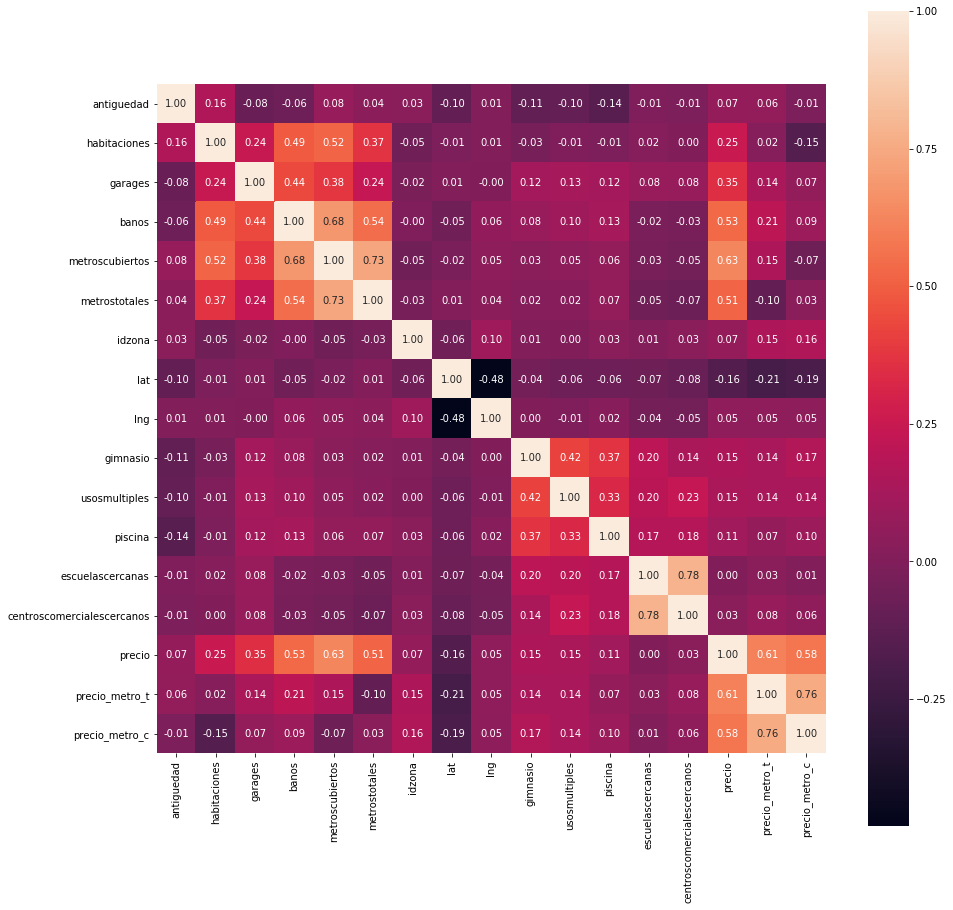

In [44]:
# Matriz de correlaciones como heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr().dropna(), square=True, annot=True, fmt='.2f');

In [28]:
df['year'] = df['fecha'].dt.year

In [ ]:
#df2=df.groupby('year')['precio'].mean()
#df.tipodepropiedad.corr(df.precio)
corr = df[['tipodepropiedad','precio','year']]

In [20]:
df.pivot(index=df.year,columns=df.tipodepropiedad,values=pd).T


AttributeError: 'DataFrame' object has no attribute 'year'

[]

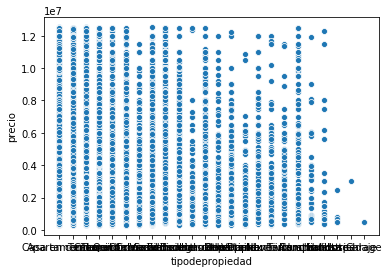

In [8]:
sns.scatterplot(x="tipodepropiedad", y="precio", data=df).plot()

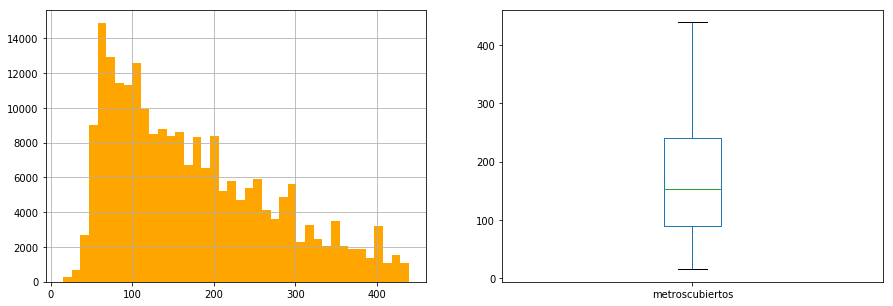

In [54]:
# Distribución de metros cubiertos
_, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.ticklabel_format(style = 'plain')
df['metroscubiertos'].hist(bins=40, ax=axes[0], color='orange');
df['metroscubiertos'].plot(kind='box', ax=axes[1]);